<a href="https://colab.research.google.com/github/oliviasteeed/Computer-Vision-Project/blob/main/computervision_actual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Project: Text detection from images
This project identifies and types out written words from images. It uses object detection to find where text is in an image, and then classification to identify the word.

v2

### Set up ultralytics and install dependencies

In [1]:
!pip3 install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
Setup complete ✅ (4 CPUs, 8.0 GB RAM, 299.4/894.1 GB disk)


In [2]:
import cv2
import matplotlib.pyplot as plt
import random as random
import os
import glob
%matplotlib inline
from PIL import Image
from ultralytics import YOLO

# 1. Text Detection

Detecting where text is in an image, and cropping images with text to bounding boxes

### Data Preprocessing

Datasets: three text detection datasets of images/screenshots with text enclosed in bounding boxes. I was going to try object detection for just handwriting, but found more data for typed text, so this model is intended to identify both with a bias for typed text. Because of this, the use case could also be for translation of typed text.

https://universe.roboflow.com/yolo-2uwb2/text-detection-jqlql

https://universe.roboflow.com/yolov5-train/yolo-find-text

https://universe.roboflow.com/akshithak-0pa4q/text-detection-qj5wx

potentially add this one? handwritten text: https://universe.roboflow.com/project-geapn/handwritten-letters-nydu4

In [ ]:
image_dir = '/Users/oliviasteed/Desktop/Text Dataset/images'
label_dir = '/Users/oliviasteed/Desktop/Text Dataset/labels'

dir = '/Users/oliviasteed/Desktop/Text Dataset'

In [ ]:
# write yaml file - did it this way so I could specify directory

with open('/Users/oliviasteed/Desktop/Text Dataset/config.yaml', 'w') as file:
    file.write('''\
path: /Users/oliviasteed/Desktop/Text Dataset
train: /Users/oliviasteed/Desktop/Text Dataset/images/train
test: /Users/oliviasteed/Desktop/Text Dataset/images/test
val: /Users/oliviasteed/Desktop/Text Dataset/images/val

# Classes
nc: 1

# Class names
names: ['Text']
''')

Draw a label bounding box to check accuracy

In [ ]:
# showing label - to check if it is labeled right (it is)
%matplotlib inline
from PIL import Image

def draw_yolo_bbox(image_path, label_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Read label file
    with open(label_path, 'r') as file:
        bboxes = file.readlines()

    # Draw each bbox
    for bbox in bboxes:
        class_id, x_center, y_center, bbox_width, bbox_height = [float(x) for x in bbox.split()]

        # Convert YOLO bbox format to rectangle coordinates
        x1 = int((x_center - bbox_width / 2) * width)
        y1 = int((y_center - bbox_height / 2) * height)
        x2 = int((x_center + bbox_width / 2) * width)
        y2 = int((y_center + bbox_height / 2) * height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put label (class_id) near the bbox
        # label = class_labels[int(class_id)]
        label = "text"
        cv2.putText(image, label, (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    # Display image
    plt.imshow(image)
    # Image.open(image)
    plt.axis('off')
    plt.savefig('test.jpg')
    return

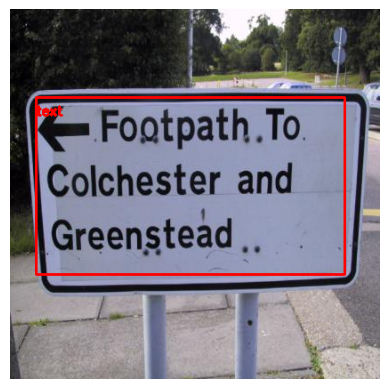

In [ ]:
draw_yolo_bbox("/Users/oliviasteed/Desktop/Text Dataset/images/train/100_jpg.rf.072e86458094f004ab381eb018f48ea0.jpg", "/Users/oliviasteed/Desktop/Text Dataset/labels/train/100_jpg.rf.072e86458094f004ab381eb018f48ea0.txt")

Check if there is unlabeled data

In [ ]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)

In [ ]:
print(len(image_files_val), "  =  ", len(label_files_val))

243   =   243


In [ ]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


No unlabeled data, so we can move on to model training.

### Transfer Learning for Object Detection

In [ ]:
# from ultralytics import YOLO

# make new model to train and load in weights from existing YOLO detection model
model = YOLO("yolov8n.yaml").load("yolov8n.pt")

# train model with text object detection data
results = model.train(data="/Users/oliviasteed/Desktop/Text Dataset/config.yaml", epochs=8, patience=5, batch=8, lr0=0.0005)

Transferred 355/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.3.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Text Dataset/config.yaml, epochs=8, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=yolov8n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnosti

train: Scanning /Users/oliviasteed/Desktop/Text Dataset/labels/train.cache... 84
val: Scanning /Users/oliviasteed/Desktop/Text Dataset/labels/val.cache... 247 im


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      1.301      1.651      1.202          2        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652       0.77      0.782      0.825      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8         0G      1.202      1.177      1.148          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.901      0.839      0.907       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8         0G      1.185      1.087      1.152          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.918      0.859      0.941      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8         0G      1.149     0.9795      1.136          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.919      0.902      0.955       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8         0G      1.098     0.8674      1.103          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.959      0.894      0.969      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8         0G      1.055     0.8059      1.094          3        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.952      0.907      0.971      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8         0G      1.046     0.7768      1.077         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652       0.96      0.923      0.973      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8         0G      1.005     0.7216      1.068         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        247        652      0.949       0.95      0.981      0.717



8 epochs completed in 1.702 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        247        652      0.949      0.949      0.981      0.717
Speed: 5.1ms preprocess, 215.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train3


### Validation
I want to minimize errors with bounding boxes so will use IoU and Precision, plus mAP for an overview of model performance.

In [ ]:
metrics = model.val() # general validation

metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/oliviasteed/Desktop/Text Dataset/labels/val.cache... 247 im
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        247        652      0.949      0.949      0.981      0.717
Speed: 5.6ms preprocess, 286.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train32


0.9492219119233806

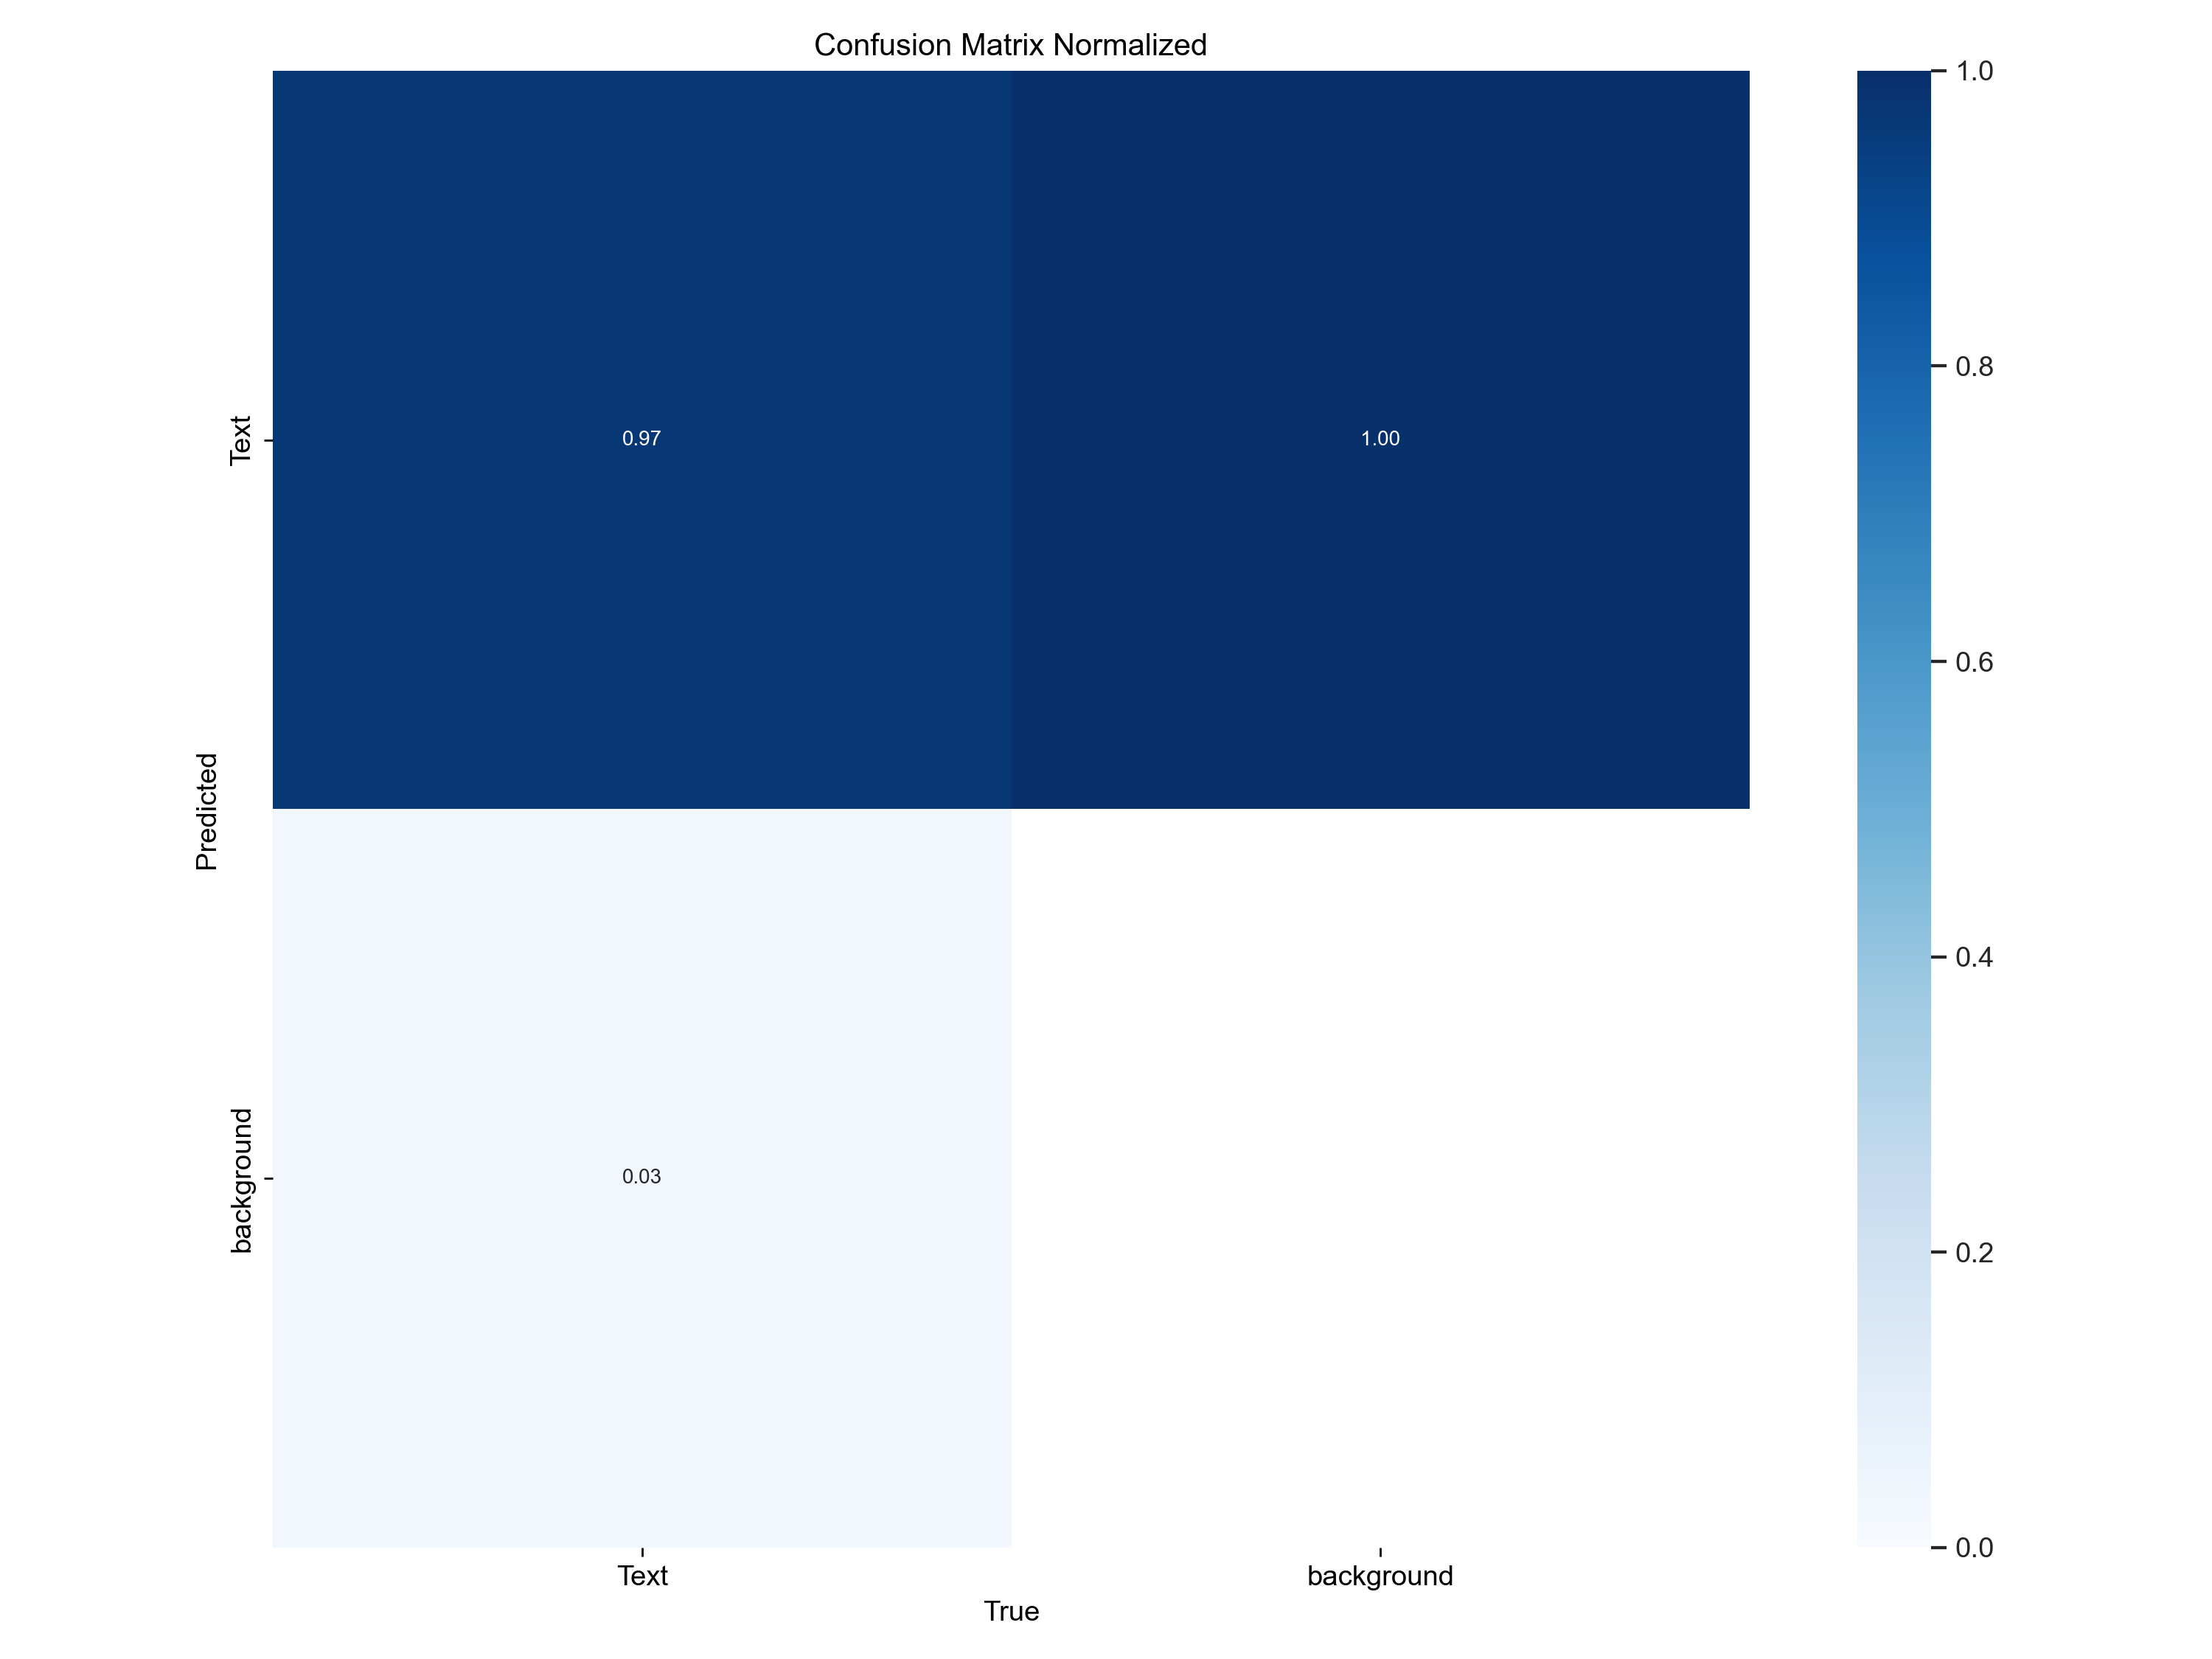

In [ ]:
# show confusion matrix to analyze overall accuracy

# %matplotlib inline
# from PIL import Image

Image.open('/Users/oliviasteed/runs/detect/train3/confusion_matrix_normalized.png')

### Test (Text detection)

Testing model on test set images

In [ ]:
# load saved model (so don't have to train it again)
model = YOLO("/Users/oliviasteed/runs/detect/train3/weights/best.pt")  # this is the model path

In [ ]:
# test model with test data

model("/Users/oliviasteed/Desktop/Text Dataset/images/test/155_jpg.rf.d4e4cbd876dfc69f09f1361c21eab6c2.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/Text Dataset/images/test/155_jpg.rf.d4e4cbd876dfc69f09f1361c21eab6c2.jpg: 640x640 1 Text, 647.1ms
Speed: 13.6ms preprocess, 647.1ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [128, 118, 118],
         [128, 118, 118],
         [128, 118, 118]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [128, 118, 118],
         [128, 118, 118],
         [128, 118, 118]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [128, 118, 118],
         [128, 118, 118],
         [128, 118, 118]],
 
        ...,
 
        [[  7,   0,   6],
         [  7,   0,   6],
         [  6,   0,   5],
         ...,
         [ 11,  10,  12],
         [ 11,  10,  12],
         [ 11,  10,  12]],
 
        [[  7,   0,   6],
         [  7,   0,   6],
         [  6,   0,   5],
         ...,
         [ 12,  11, 

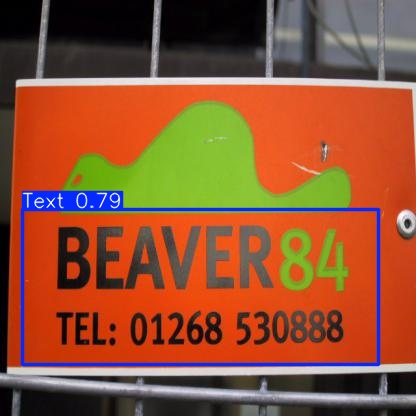

In [ ]:
# show prediction
Image.open('/Users/oliviasteed/runs/detect/predict3/155_jpg.rf.d4e4cbd876dfc69f09f1361c21eab6c2.jpg')

In [ ]:
# test on test data

model("/Users/oliviasteed/Desktop/Text Dataset/images/test/247_jpg.rf.5461f352ec6e9688c685cff96665a0aa.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/Text Dataset/images/test/247_jpg.rf.5461f352ec6e9688c685cff96665a0aa.jpg: 640x640 5 Texts, 442.9ms
Speed: 21.5ms preprocess, 442.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[132,  80,  44],
         [133,  81,  45],
         [133,  81,  45],
         ...,
         [113,  68,  34],
         [113,  68,  34],
         [113,  68,  34]],
 
        [[131,  79,  43],
         [132,  80,  44],
         [132,  80,  44],
         ...,
         [114,  69,  35],
         [113,  68,  34],
         [113,  68,  34]],
 
        [[130,  78,  42],
         [131,  79,  43],
         [132,  80,  44],
         ...,
         [114,  69,  36],
         [114,  69,  36],
         [113,  68,  35]],
 
        ...,
 
        [[113,  66,  39],
         [113,  66,  39],
         [112,  65,  38],
         ...,
         [ 99,  59,  34],
         [ 99,  59,  34],
         [ 98,  58,  33]],
 
        [[112,  65,  38],
         [112,  65,  38],
         [111,  64,  37],
         ...,
         [ 99,  59, 

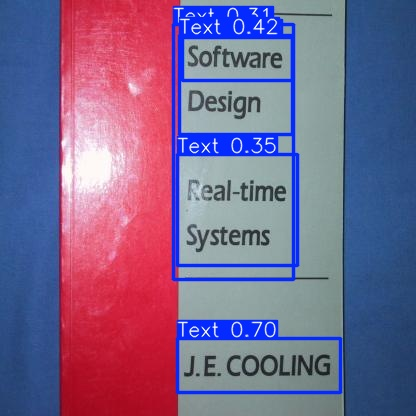

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/predict3/247_jpg.rf.5461f352ec6e9688c685cff96665a0aa.jpg')

In [ ]:
# test on test image
model("/Users/oliviasteed/Desktop/Text Dataset/images/test/Ar_26_An_26_TNR_26_Image199_jpg.rf.fe1402471423e1f6c51ae59e3020c1d3.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/Text Dataset/images/test/Ar_26_An_26_TNR_26_Image199_jpg.rf.fe1402471423e1f6c51ae59e3020c1d3.jpg: 640x640 3 Texts, 277.7ms
Speed: 7.5ms preprocess, 277.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[251, 254, 238],
         [251, 254, 238],
         [251, 254, 239],
         ...,
         [255, 226, 191],
         [255, 226, 191],
         [255, 226, 191]],
 
        [[251, 254, 238],
         [251, 254, 238],
         [252, 255, 240],
         ...,
         [255, 226, 191],
         [255, 226, 191],
         [255, 226, 191]],
 
        [[251, 254, 239],
         [252, 255, 240],
         [252, 255, 240],
         ...,
         [255, 225, 192],
         [255, 226, 193],
         [255, 226, 193]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [124, 115, 106],
         [126, 116, 109],
         [122, 113, 104]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [126, 116, 

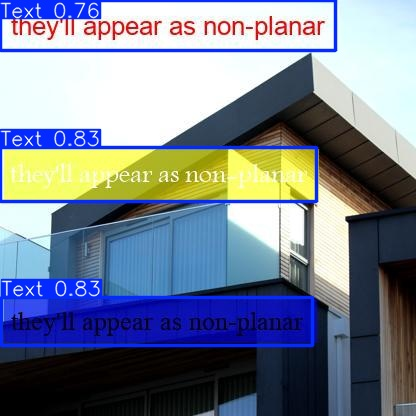

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/predict3/Ar_26_An_26_TNR_26_Image199_jpg.rf.fe1402471423e1f6c51ae59e3020c1d3.jpg')

In [ ]:
# test on test image
model("/Users/oliviasteed/Desktop/Text Dataset/images/test/66_png.rf.0c3431b7e21b2e8076ce3450db980dd8.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/Text Dataset/images/test/66_png.rf.0c3431b7e21b2e8076ce3450db980dd8.jpg: 640x640 4 Texts, 339.5ms
Speed: 6.1ms preprocess, 339.5ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 

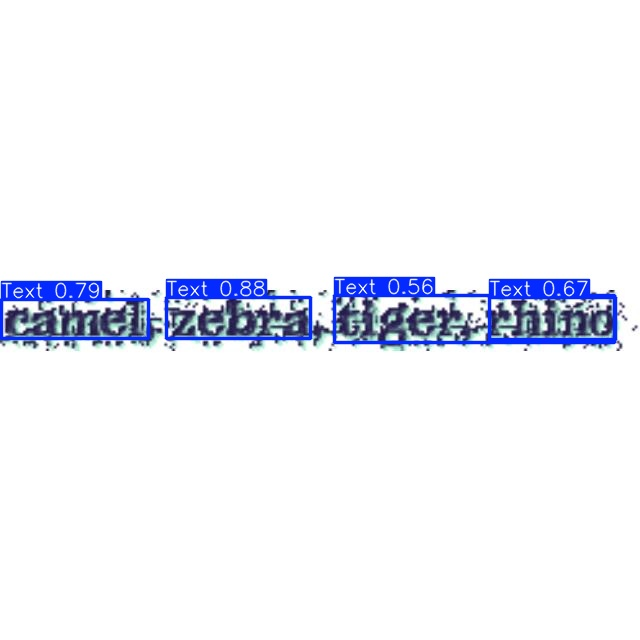

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/predict3/66_png.rf.0c3431b7e21b2e8076ce3450db980dd8.jpg')

In [ ]:
# test on image of writing I did

model("/Users/oliviasteed/Desktop/IMG_9534.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpg: 288x640 1 Text, 200.8ms
Speed: 3.5ms preprocess, 200.8ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[170, 176, 175],
         [167, 173, 172],
         [164, 170, 169],
         ...,
         [165, 171, 170],
         [164, 170, 169],
         [163, 169, 168]],
 
        [[170, 176, 175],
         [167, 173, 172],
         [164, 170, 169],
         ...,
         [165, 171, 170],
         [164, 170, 169],
         [163, 169, 168]],
 
        [[170, 176, 175],
         [167, 173, 172],
         [164, 170, 169],
         ...,
         [165, 171, 170],
         [164, 170, 169],
         [163, 169, 168]],
 
        ...,
 
        [[155, 161, 160],
         [158, 164, 163],
         [162, 168, 167],
         ...,
         [162, 168, 167],
         [163, 169, 168],
         [164, 170, 169]],
 
        [[152, 158, 157],
         [155, 161, 160],
         [160, 166, 165],
         ...,
         [157, 163, 

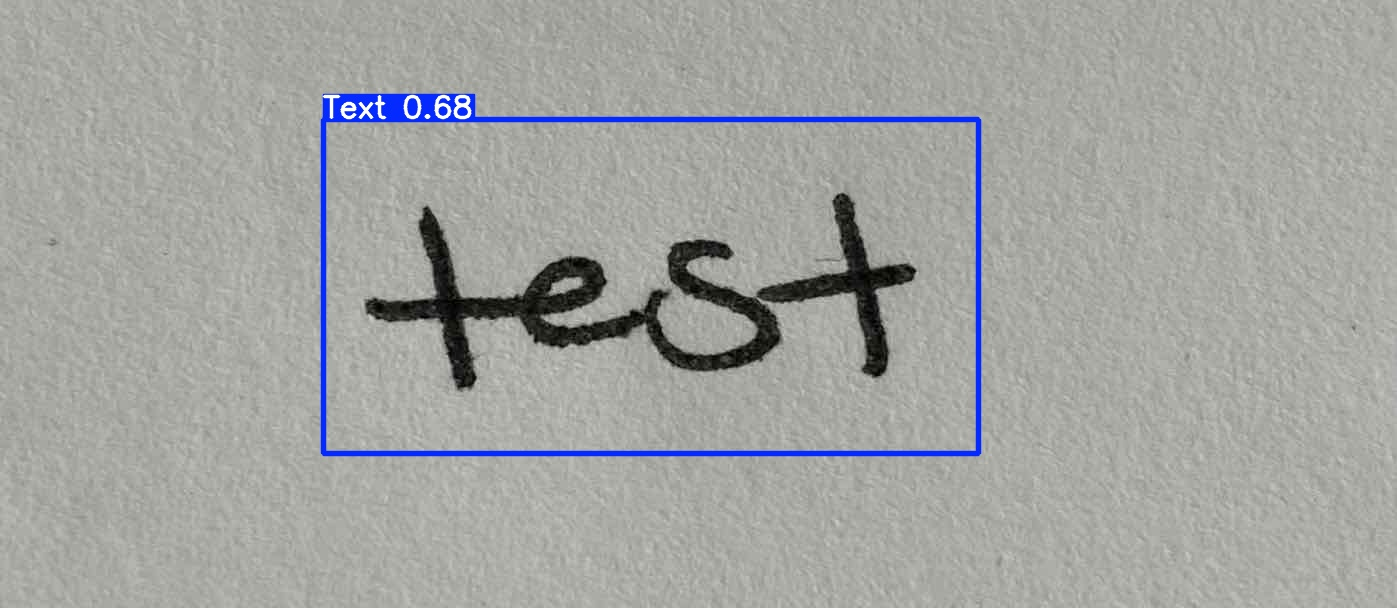

In [ ]:
Image.open('/Users/oliviasteed/runs/detect/predict3/IMG_9534.jpg')

## Crop image around text bounding box

To detect letters, we only want to pass in text bounding box, so we will crop it around text bounding boxes.

In [ ]:
# predict on image to get text bounding box

results = model("/Users/oliviasteed/Desktop/IMG_9534.jpg")


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpg: 288x640 1 Text, 180.3ms
Speed: 2.0ms preprocess, 180.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


In [ ]:
# used these as references for getting bounding box and saving to new image
# https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924#:~:text=In%20Yolo%2C%20the%20bounding%20box,centre%20of%20the%20bounding%20box.
# https://github.com/ultralytics/ultralytics/issues/2143

# make results bounding box into list of coordinates

for result in results[0].boxes.xyxy:  # Iterate through detected objects
    x_min, y_min, x_max, y_max = result.tolist()

    print(f'Bounding box: ({x_min}, {y_min}, {x_max}, {y_max})')

Bounding box: (323.46038818359375, 119.45033264160156, 978.3939819335938, 453.9836730957031)


In [ ]:
image_name = "IMG_9534"

# load predicted test image
image_path = f'/Users/oliviasteed/runs/detect/predict/{image_name}.jpg'
image = cv2.imread(image_path)

box_width = int(x_max - x_min)
box_height = int(y_max - y_min)

# print(box_width,",",box_height)

cropped_region = image[int(y_min):int(y_max), int(x_min):int(x_max)]
cv2.imwrite(f'/Users/oliviasteed/runs/detect/predict/{image_name}textcrop.jpg', cropped_region)


True

In [ ]:
# predict and save all in one function (trying on this)

def predict_object_detection(image_path, file_name):
  # output_path = file_name + "bbox.jpg"
  # results = model(image_path, save=True, project=output_path)
  results = model(image_path, save=True)
  #how to save with custom name?

#add check in case no detection

  for result in results[0].boxes.xyxy:  # Iterate through detected objects
    x_min, y_min, x_max, y_max = result.tolist()

  # load predicted test image
  # image = cv2.imread(output_path)
  image = cv2.imread("/Users/oliviasteed/runs/detect/predict3/IMG_9534.jpg")

  box_width = int(x_max - x_min)
  box_height = int(y_max - y_min)

  # print(box_width,",",box_height)

  crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
  cv2.imwrite(image_path + "textcrop.jpg", crop)





In [ ]:
predict_object_detection("/Users/oliviasteed/Desktop/IMG_9534.jpg", "IMG_9534")


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpg: 288x640 1 Text, 228.2ms
Speed: 22.0ms preprocess, 228.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Results saved to runs/detect/predict3


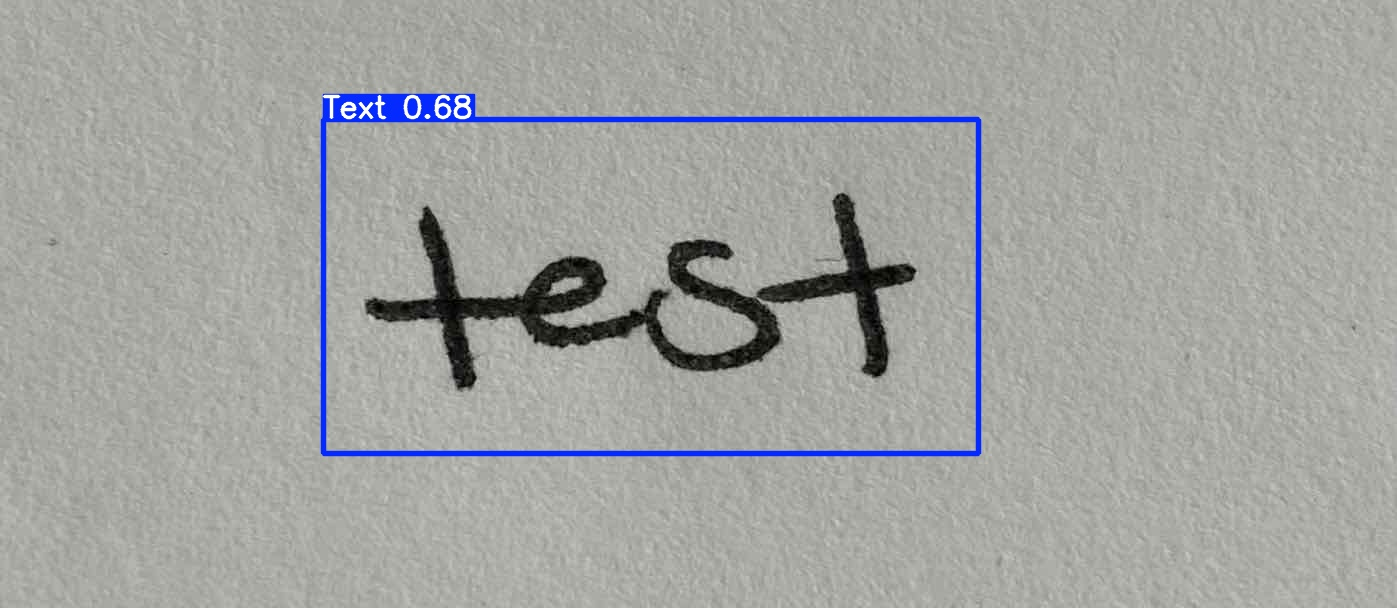

In [ ]:
# original image
Image.open("/Users/oliviasteed/runs/detect/predict3/IMG_9534.jpg")

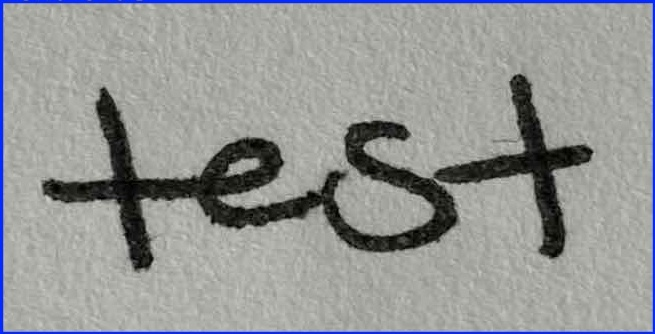

In [ ]:
# cropped image
Image.open("/Users/oliviasteed/Desktop/IMG_9534.jpgtextcrop.jpg")

# 2. Letters Detection

Identifying the letters in cropped text images and printing it out into console.

## Data preprocessing

Datasets: two datasets with images/screenshots of text with labeled bounding boxes around each letter.

https://universe.roboflow.com/yolo-3ovhz/letters-xsg2w

https://universe.roboflow.com/arturs-jelagins-a8sef/supercaptcha

In [ ]:
# write yaml file - did it this way so I could specify directory

with open('/Users/oliviasteed/Desktop/Letters Dataset/config.yaml', 'w') as file:
    file.write('''\
path: /Users/oliviasteed/Desktop/Letters Dataset
train: /Users/oliviasteed/Desktop/Letters Dataset/images/train
test: /Users/oliviasteed/Desktop/Letters Dataset/images/test
val: /Users/oliviasteed/Desktop/Letters Dataset/images/val

# Classes
nc: 50

# Class names
names: ['.', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'S', 'T', 'U', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

''')

In [3]:
# train new model for letter detection based on previous text tuned model
model2 = YOLO("yolov8n.yaml").load("/Users/oliviasteed/runs/detect/train3/weights/best.pt")

# train model with labeled letter data first
result2 = model2.train(data="/Users/oliviasteed/Desktop/Letters Dataset/Letters/data.yaml", epochs=8, patience=5, batch=8, lr0=0.0005)


Transferred 319/355 items from pretrained weights
New https://pypi.org/project/ultralytics/8.3.25 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Letters Dataset/Letters/data.yaml, epochs=8, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=/Users/oliviasteed/runs/detect/train3/weights/best.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_

train: Scanning /Users/oliviasteed/Desktop/Letters Dataset/Letters/train/labels.
val: Scanning /Users/oliviasteed/Desktop/Letters Dataset/Letters/valid/labels.ca


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000357, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train10
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      3.628      4.723      3.196        151        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8         0G      2.793      4.499      2.376        124        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8         0G      2.382      4.311      2.047        105        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500    0.00897      0.322     0.0136    0.00503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8         0G      2.129      4.172      1.873        169        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0553      0.514     0.0473     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8         0G      1.941       4.03      1.765        146        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0646      0.586     0.0605     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8         0G      1.797      3.911      1.671         90        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0255      0.612     0.0491     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8         0G       1.76      3.825      1.673         98        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0245      0.631     0.0513     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8         0G      1.735      3.792      1.641        145        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         57        500     0.0214      0.656      0.054     0.0301



8 epochs completed in 0.466 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.3MB

Validating runs/detect/train10/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,010,328 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         57        500     0.0554      0.516     0.0473      0.032
                     .         13         18          0          0          0          0
                     0         14         19     0.0237      0.368     0.0273     0.0124
                     1         13         14    0.00824      0.571     0.0154    0.00613
                     2         16         19     0.0126      0.842     0.0224    0.00881
                     5         23         25     0.0181       0.68     0.0159    0.00588
                     6         21         26          0          0          0          0
                     8         14         18          1     0.0556      0.528      0.475
                     A         20         24     0.0355      0.417     0.0363     0.0168
                     B         12         15     0.0121          1     0.0364     0.0154
                     C         13         14    0.00968          1     0.0192    0.00845
                     

In [4]:
# train model with captcha data 1
result3 = model2.train(data="/Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha/data.yaml", epochs=8, patience=5, batch=8, lr0=0.0005)

New https://pypi.org/project/ultralytics/8.3.25 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha/data.yaml, epochs=8, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train102, exist_ok=False, pretrained=/Users/oliviasteed/runs/detect/train3/weights/best.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False

train: Scanning /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha/train/la

train: New cache created: /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha/train/labels.cache



val: Scanning /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha/valid/labe

val: New cache created: /Users/oliviasteed/Desktop/Letters Dataset/SuperCaptcha/valid/labels.cache


Plotting labels to runs/detect/train102/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000204, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train102
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      2.092      4.941      1.837         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0063     0.0596     0.0077    0.00267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8         0G      1.556      4.774      1.452         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0148      0.137     0.0218     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8         0G      1.327      4.537      1.304         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0413      0.353     0.0492     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8         0G      1.181      4.377       1.21         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0217       0.57     0.0512     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8         0G       1.13      4.239      1.174         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0199      0.697     0.0647      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8         0G      1.103      4.125      1.167         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0221      0.726     0.0748     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8         0G      1.038      4.074      1.119         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0236      0.753     0.0832     0.0621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8         0G      1.019      4.019      1.119         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        105        735     0.0242      0.753     0.0899     0.0675



8 epochs completed in 0.517 hours.
Optimizer stripped from runs/detect/train102/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train102/weights/best.pt, 6.3MB

Validating runs/detect/train102/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
YOLOv8n summary (fused): 168 layers, 3,014,423 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        105        735     0.0242      0.753     0.0902     0.0677
                     A         15         16     0.0103          1     0.0252     0.0142
                     B         15         16     0.0165          1      0.117     0.0969
                     C         16         17     0.0127          1     0.0451     0.0318
                     D         16         17     0.0181          1      0.357      0.257
                     E         18         19     0.0231          1      0.278      0.234
                     F         14         14    0.00749      0.143    0.00429     0.0028
                     G         19         22     0.0346          1     0.0985     0.0856
                     H         19         20     0.0128          1     0.0522     0.0405
                     J         15         18      0.014          1     0.0231     0.0157
                     K         16         16     0.0173          1      0.137      0.122
                     

In [ ]:
# train model with captcha data 2 (they are trained separately because the values in the yaml do not line up)
result4 = model2.train(data="/Users/oliviasteed/Desktop/Letters Dataset/NewCaptcha/data.yaml", epochs=8, patience=5, batch=8, lr0=0.0005)

New https://pypi.org/project/ultralytics/8.3.26 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.17 🚀 Python-3.12.6 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/oliviasteed/Desktop/Letters Dataset/NewCaptcha/data.yaml, epochs=8, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train1022, exist_ok=False, pretrained=/Users/oliviasteed/runs/detect/train3/weights/best.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False,

train: Scanning /Users/oliviasteed/Desktop/Letters Dataset/NewCaptcha/train/labe


train: New cache created: /Users/oliviasteed/Desktop/Letters Dataset/NewCaptcha/train/labels.cache


val: Scanning /Users/oliviasteed/Desktop/Letters Dataset/NewCaptcha/valid/labels

val: New cache created: /Users/oliviasteed/Desktop/Letters Dataset/NewCaptcha/valid/labels.cache
Plotting labels to runs/detect/train1022/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000152, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train1022
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8         0G      1.954      4.561      1.539         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all          8         44     0.0342      0.871      0.209      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8         0G      1.755      3.789      1.407         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all          8         44      0.551      0.348      0.296      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8         0G      1.684      3.367      1.406         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all          8         44      0.529      0.424      0.509      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8         0G      1.656      3.108        1.4         96        640:  

In [ ]:
# load letter detection model once trained
model2 = YOLO("/Users/oliviasteed/runs/detect/train3/weights/best.pt")  # this is the model path

In [ ]:
# test model with test images

model2("/Users/oliviasteed/Desktop/IMG_9534.jpgtextcrop.jpg", save=True)


image 1/1 /Users/oliviasteed/Desktop/IMG_9534.jpgtextcrop.jpg: 352x640 (no detections), 1045.7ms
Speed: 8.5ms preprocess, 1045.7ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/train534


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '.', 1: '0', 2: '1', 3: '2', 4: '5', 5: '6', 6: '8', 7: 'A', 8: 'B', 9: 'C', 10: 'D', 11: 'E', 12: 'G', 13: 'H', 14: 'I', 15: 'J', 16: 'K', 17: 'L', 18: 'M', 19: 'N', 20: 'O', 21: 'S', 22: 'T', 23: 'U'}
 obb: None
 orig_img: array([[[247,  42,   4],
         [249,  42,   4],
         [255,  43,   4],
         ...,
         [254,  43,   6],
         [253,  41,   1],
         [255,  46,   4]],
 
        [[247,  39,   3],
         [252,  44,   8],
         [255,  48,  12],
         ...,
         [242,  44,   8],
         [250,  47,  10],
         [250,  41,   3]],
 
        [[255,  44,  10],
         [246,  42,   7],
         [226,  33,   0],
         ...,
         [212,  42,  14],
         [229,  40,   9],
         [249,  43,   8]],
 
        ...,
 
        [[255,  44,  13],
         [247,  45,  14],
         [213,  41,  13],
         ...